<a href="https://colab.research.google.com/github/CDAC-lab/ETFA-Workshop/blob/main/Convolution%20Neural%20Networks%20for%20Defect%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution Neural Networks for Image Classification

In this workshop we will use a CNN to identify defective casting products.    We will use a [casting defect](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product) dataset hosted on Kaggle. 

Our goal is to classify the casting products in the dataset into 2 classes, **Defective** and **Not Defective**. 

The dataset contains 7438 grayscale images, with resolution of 300x300 pixels.

We will use 6,633 images to train the classification CNN and 715 images to evaluate the accuracy of the network.


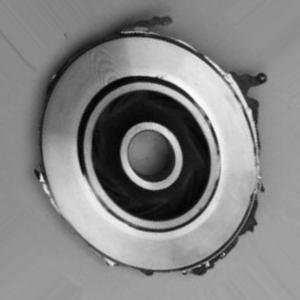 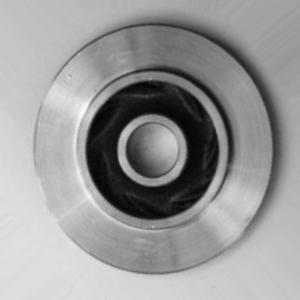

## Enable GPU

CPUs are designed for more general computing workloads.  GPUs in contrast are less flexible, however GPUs are designed for parallel  computations. Deep Neural Networks (DNN) are structured in a very uniform manner such that at each layer of the network thousands of identical artificial neurons perform the same computation.   Therefore the structure of a DNN fits quite well with the kinds of computation that a GPU can efficiently perform.

To enable GPU in Google Colab, 


1. Click on Runtime menu on the toolbar
2. Select change runtime type
3. Select GPU for Hardware Acceleration option list.
4. Select SAVE.



## Download the dataset

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Authenticate and create the PyDrive client.

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

When prompted, click on the link to get authentication to allow Google to access your Drive. You should see a screen with “Google Cloud SDK wants to access your Google Account” at the top. After you allow permission, copy the given verification code and paste it in the box in Colab.

In [4]:
dataset_file_id = '1o4x0W517MdOUYMzvjcHN24pCDpSiGIZH'

In [5]:
downloaded = drive.CreateFile({'id':dataset_file_id}) 
downloaded.GetContentFile('CNN-Dataset.zip')

Extract the Dataset


In [6]:
!unzip -q CNN-Dataset.zip -d data

Data description can be found from [this link](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product).

In [7]:
# Load Tensorflow library preprocessing tools
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [8]:
data_dir = './data/casting_data/casting_data/'
train_path = data_dir + 'train/'
test_path = data_dir + 'test/'

## Explore and pre-process the data

### Preprocessing

We normalize the image by multiplying by a constant value. We used 1/255 as the constant so that the value of each pixel would be in the range [0.0,1.0]




### Image Augmentation

Image augmentation is a technique of altering the existing data to create some more data for the model training process.


Here we used 3 image augmentation methods,


1.   Random Zoom - Randomly zoom in and out of the image. [lower, upper] = [1-zoom_range, 1+zoom_range]

2. Horizontal Flip - Randomly flip inputs horizontally.

3. Vertical Flip - Randomly flip inputs vertically.

![Source : https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/](https://nanonets.com/blog/content/images/2018/11/1_C8hNiOqur4OJyEZmC7OnzQ.png)



Define the data loader

In [9]:
train_image_loader = ImageDataGenerator(rescale=1/255, 
                                        zoom_range=0.1,
                                        horizontal_flip=1,
                                        vertical_flip=1)

# No augmentations for the test image loader
test_image_loader = ImageDataGenerator(rescale=1/255)


You can check all the augmentation methods offered by Tensorflow by visting this [link](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) 

In [10]:
# Define constants
BATCH_SIZE = 32
IMAGE_DIM = (300, 300, 1)

Load training and testing splits

In [11]:
train_split = train_image_loader.flow_from_directory(train_path, # training data path
                                            target_size=IMAGE_DIM[:2], # desired output size (300,300)
                                            color_mode="grayscale",
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle=True,
                                            seed=0)

test_split = test_image_loader.flow_from_directory(test_path,
                                           target_size=IMAGE_DIM[:2],
                                           color_mode="grayscale",
                                           batch_size=BATCH_SIZE,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=0)

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


Let's look at our class names and class indices

In [12]:
test_split.class_indices


{'def_front': 0, 'ok_front': 1}

We have two classes **def_front** and **ok_front** which corresponds to **Defective** and **Not Defective** product.



In [13]:
# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Import numpy library to process matrices
import numpy as np

Display the first batch from the training set and display the class name above each image.   
It is important to verify that the data is in the correct format before building the model.

In [14]:
def plot_batch(images, labels,rows,cols):

    fig = plt.figure(figsize = (20, 8))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]
        ax.imshow(np.squeeze(image),cmap='gray')
        label = "Not Defective" if labels[i][1] else "Defective"
        ax.set_title(label,loc='center',wrap=True,)
        ax.axis('off')

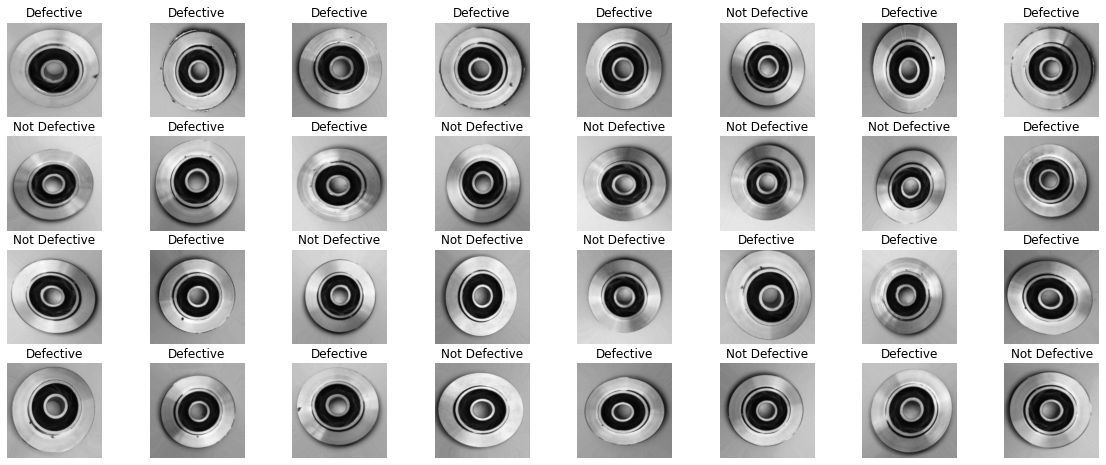

In [15]:
images, labels = train_split[0][0],train_split[0][1]
plot_batch(images, labels,rows=4,cols=8)

## Model Building

In this workshop, we will develop 3 deep learning models with increasing complexity to evaluate the classification accuracy.  


1.   3 Layer DNN
2.   1 Layer CNN
3.   3 Layer CNN

## 3-DNN Model

In this DNN model, we flatten the 300x300 image into a 90,000 input feature vector.  
It should be noted that with flattening we will face the inherent problems  (i.e., scale, rotation, location, high-demensionality)

In [16]:
# Import Keras libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model

In [17]:
dnn3_model = Sequential()

In [18]:
dnn3_model.add(Flatten(input_shape=IMAGE_DIM))  # Add Keras Flatten layer to conver (300x300) image -> 90000 feature vector

In [19]:
dnn3_model.add(Dense(128, activation='relu')) 
dnn3_model.add(Dense(64, activation='relu')) 
dnn3_model.add(Dense(2, activation='softmax'))  # In the final layer we use softmax activation to classify the input into 2 classes.

Softmax is an activation function that turns logits into probabilities that sum to one. E.g.,

---


 
![alt text](https://cdn-images-1.medium.com/max/906/1*670CdxchunD-yAuUWdI7Bw.png)

For a complete understanding of available activation functions, please refer the following resources:  


1.   [ML Cheatsheat](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html)
2.   [Towards data science](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)




**Compiling the model**

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:  

* Loss function —This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction. [Further details](https://keras.io/losses/) 
* Optimizer —This is how the model is updated based on the data it sees and its loss function. [Further details.](https://keras.io/optimizers/)
* Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified. [Further details.](https://keras.io/metrics/) 

In [20]:
dnn3_model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Summary of the model



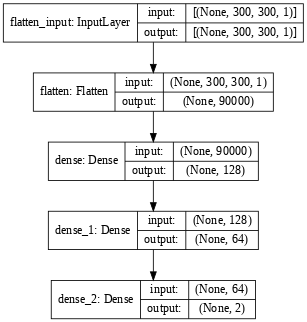

In [21]:
plot_model(dnn3_model, show_shapes=True, expand_nested=True, dpi=60)

Initially, we will train the model for 10 learning epochs. Based on the learning curve, visualized below, you could update this hyper-parameter to best fit the training data.

In [22]:
# Train the model
epochs = 10
history = dnn3_model.fit(train_split,epochs=epochs)

Epoch 1/10
208/208 [==============================] - 57s 261ms/step - loss: 2.0864 - accuracy: 0.6243
Epoch 2/10
208/208 [==============================] - 54s 262ms/step - loss: 0.7251 - accuracy: 0.6829
Epoch 3/10
208/208 [==============================] - 54s 260ms/step - loss: 0.6486 - accuracy: 0.6947
Epoch 4/10
208/208 [==============================] - 54s 262ms/step - loss: 0.5860 - accuracy: 0.7101
Epoch 5/10
208/208 [==============================] - 54s 261ms/step - loss: 0.5270 - accuracy: 0.7434
Epoch 6/10
208/208 [==============================] - 55s 262ms/step - loss: 0.5319 - accuracy: 0.7386
Epoch 7/10
208/208 [==============================] - 54s 261ms/step - loss: 0.5293 - accuracy: 0.7339
Epoch 8/10
208/208 [==============================] - 54s 260ms/step - loss: 0.5449 - accuracy: 0.7310
Epoch 9/10
208/208 [==============================] - 55s 264ms/step - loss: 0.5326 - accuracy: 0.7389
Epoch 10/10
208/208 [==============================] - 54s 259ms/step - l

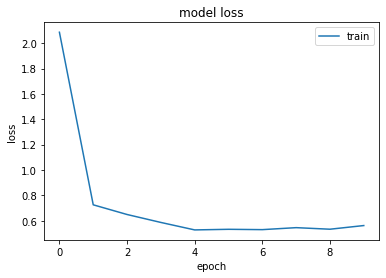

In [23]:
# Visualize the training curve
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

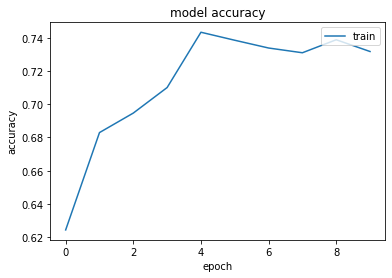

In [24]:
# Visualize accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Load from saved pretrained model

In [25]:
# dnn3_model_downloaded = drive.CreateFile({'id':'107c4Ps0Nfw36xmmhc0vmX3ylmDD1ndd1'}) 
# dnn3_model_downloaded.GetContentFile('dnn3_h5.h5')

In [26]:
# from tensorflow.keras.models import load_model
# dnn3_model = load_model('dnn3_h5.h5')


### Testing accuracy

In [27]:
test_loss, test_acc = dnn3_model.evaluate(test_split)
print('Test accuracy:', test_acc)

23/23 [==============================] - 2s 73ms/step - loss: 0.5275 - accuracy: 0.7818
Test accuracy: 0.7818182110786438


## 1-CNN

CNN is specifically designed to process two-dimensional data spaces (focusing on image data).  
First, we will design a single layer CNN. This will include one convolutional layer, one max pooling layer and two fully connected layers.

In [28]:
# Import required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

Construct the CNN model.

In [29]:
cnn1_model = Sequential()

Here we will use 3x3 filters (or kernals) to learn.

In [30]:
cnn1_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=IMAGE_DIM))   # We will use 32 of 3x3 kernals to learn
cnn1_model.add(MaxPooling2D(pool_size=(2, 2)))   # We use 2x2 max pooling

Flattent the previous output before sending to fully connected layers.

In [31]:
cnn1_model.add(Flatten())

We will use one fully connected (FC) layer with 64 nodes.

In [32]:
cnn1_model.add(Dense(64, activation='relu'))
cnn1_model.add(Dense(2, activation='softmax'))

In [33]:
# Compile the model
cnn1_model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

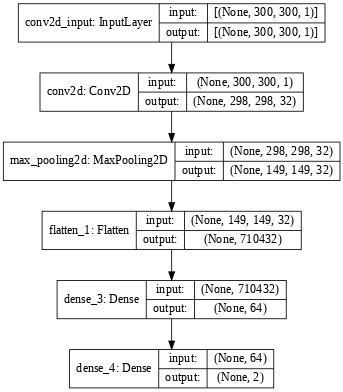

In [34]:
plot_model(cnn1_model, show_shapes=True, expand_nested=True, dpi=60)

As before, initially we will train the model for 5 epochs to evaluate the performance.  
Then, based on the accuracy/learning curve we will refine the hyper-parameters.

In [35]:
# Train the model
epochs = 5
history_1 = cnn1_model.fit(train_split, epochs=epochs)

Epoch 1/5
208/208 [==============================] - 88s 297ms/step - loss: 1.1023 - accuracy: 0.7107
Epoch 2/5
208/208 [==============================] - 62s 299ms/step - loss: 0.3707 - accuracy: 0.8366
Epoch 3/5
208/208 [==============================] - 62s 300ms/step - loss: 0.2751 - accuracy: 0.8958
Epoch 4/5
208/208 [==============================] - 62s 300ms/step - loss: 0.2124 - accuracy: 0.9225
Epoch 5/5
208/208 [==============================] - 62s 298ms/step - loss: 0.1795 - accuracy: 0.9362


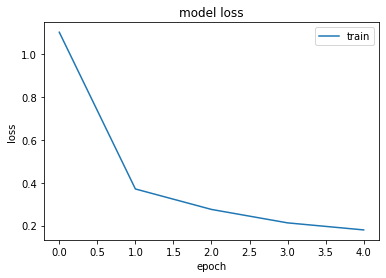

In [36]:
# Visualize the training curve
plt.plot(history_1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Load from pretrained model



In [ ]:
# cnn1_model_downloaded = drive.CreateFile({'id':'108_wUg_inXWcYTKpDDaKFXkhQJjg98B9'}) 
# cnn1_model_downloaded.GetContentFile('cnn1_h5.h5')

In [ ]:
# from tensorflow.keras.models import load_model
# cnn1_model = load_model('cnn1_h5.h5')

### Testing accuracy

In [37]:
cnn1_score = cnn1_model.evaluate(test_split)
print('Test loss:', cnn1_score[0])
print('Test accuracy:', cnn1_score[1])

23/23 [==============================] - 2s 87ms/step - loss: 0.2180 - accuracy: 0.9091
Test loss: 0.218021422624588
Test accuracy: 0.9090909361839294


By analyzing the learning curve, you should be able to identify whether training the model longer would provide better results.

## 3-CNN

In this step, we will design a complex three layer CNN intending an improvement in the accuracy.

In [38]:
# Import required libraries
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [39]:
cnn3_model = Sequential()

In [40]:
# CNN Layer 1
cnn3_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=IMAGE_DIM))
cnn3_model.add(MaxPooling2D((2, 2)))

# CNN Layer 2
cnn3_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn3_model.add(MaxPooling2D(pool_size=(2, 2)))

# CNN Layer 3
cnn3_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

In [41]:
cnn3_model.add(Flatten())  # Flatten the previous output before sending to fully connected layers

In [42]:
cnn3_model.add(Dense(128, activation='relu'))
cnn3_model.add(Dense(2, activation='softmax'))

In [43]:
# Compile the model
cnn3_model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

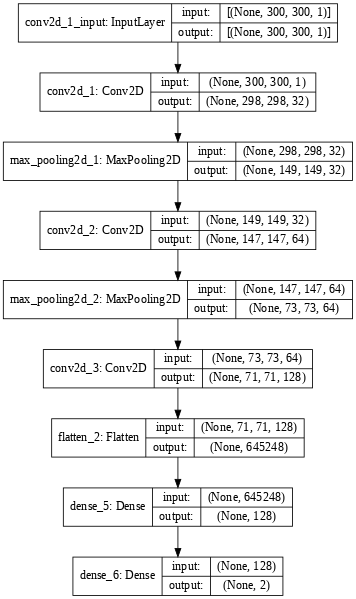

In [44]:
plot_model(cnn3_model, show_shapes=True, expand_nested=True, dpi=60)

In [45]:
# Train the model
epochs = 10
history_3 = cnn3_model.fit(train_split, epochs=epochs)

Epoch 1/10
208/208 [==============================] - 74s 344ms/step - loss: 0.8337 - accuracy: 0.6350
Epoch 2/10
208/208 [==============================] - 71s 340ms/step - loss: 0.3716 - accuracy: 0.8295
Epoch 3/10
208/208 [==============================] - 71s 343ms/step - loss: 0.2298 - accuracy: 0.9038
Epoch 4/10
208/208 [==============================] - 71s 339ms/step - loss: 0.1193 - accuracy: 0.9567
Epoch 5/10
208/208 [==============================] - 71s 340ms/step - loss: 0.1023 - accuracy: 0.9643
Epoch 6/10
208/208 [==============================] - 71s 341ms/step - loss: 0.0818 - accuracy: 0.9733
Epoch 7/10
208/208 [==============================] - 72s 343ms/step - loss: 0.0648 - accuracy: 0.9799
Epoch 8/10
208/208 [==============================] - 71s 341ms/step - loss: 0.0442 - accuracy: 0.9848
Epoch 9/10
208/208 [==============================] - 72s 343ms/step - loss: 0.0448 - accuracy: 0.9870
Epoch 10/10
208/208 [==============================] - 71s 340ms/step - l

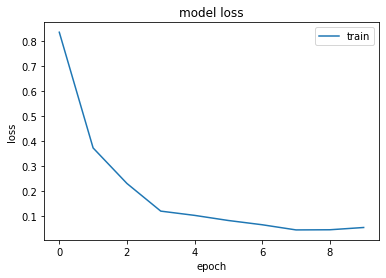

In [46]:
# Visualize the training curve
plt.plot(history_3.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

### Load from pretrained model


In [25]:
# cnn3_model_downloaded = drive.CreateFile({'id':'1-wAYwyPz0iGKz7ET8sgYFFO0nwEDH8Gz'}) 
# cnn3_model_downloaded.GetContentFile('cnn3_h5.h5')

In [27]:
# from tensorflow.keras.models import load_model
# cnn3_model = load_model('cnn3_h5.h5')

### Testing accuracy

In [47]:
cnn3_score = cnn3_model.evaluate(test_split)
print('Test loss:', cnn3_score[0])
print('Test accuracy:', cnn3_score[1])

23/23 [==============================] - 3s 109ms/step - loss: 0.0563 - accuracy: 0.9846
Test loss: 0.05634642019867897
Test accuracy: 0.9846153855323792


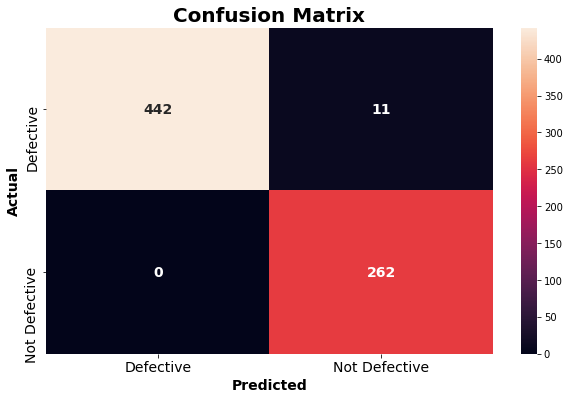

In [48]:
from sklearn.metrics import confusion_matrix, classification_report

pred_probability = cnn3_model.predict(test_split)
predictions = pred_probability.argmax(axis=1)

plt.figure(figsize=(10,6))
plt.title("Confusion Matrix", size=20, weight='bold')
sns.heatmap(
    confusion_matrix(test_split.classes, predictions),
    annot=True,
    annot_kws={'size':14, 'weight':'bold'},
    fmt='d',
    xticklabels=['Defective', 'Not Defective'],
    yticklabels=['Defective', 'Not Defective'])
plt.tick_params(axis='both', labelsize=14)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

In [49]:
print(classification_report(test_split.classes, predictions, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.976     0.988       453
           1      0.960     1.000     0.979       262

    accuracy                          0.985       715
   macro avg      0.980     0.988     0.984       715
weighted avg      0.985     0.985     0.985       715



Save Models

In [50]:
dnn3_model.save("dnn3_h5.h5")
cnn1_model.save("cnn1_h5.h5")
cnn3_model.save("cnn3_h5.h5")

## Deployment

We will deploy the trained model as a service using [FastAPI](https://fastapi.tiangolo.com/)

Install required packages

In [ ]:
!pip install fastapi, colabcode, python-multipart

In [1]:
# import required packages
from typing import Optional

from fastapi import FastAPI, File, UploadFile
from fastapi.middleware.cors import CORSMiddleware
from io import BytesIO
import numpy as np
import cv2
from tensorflow.keras.models import load_model


Download pretrained model

In [9]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

cnn3_model_downloaded = drive.CreateFile({'id':'1-wAYwyPz0iGKz7ET8sgYFFO0nwEDH8Gz'}) 
cnn3_model_downloaded.GetContentFile('cnn3_h5.h5')

Crete Fast API app instance

In [24]:
app = FastAPI()
app.add_middleware(
    CORSMiddleware,
    allow_origins=['*'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)

In [25]:
@app.on_event("startup")
def load_pretrained_model():
    global model
    model = load_model('cnn3_h5.h5')

@app.post("/predict/")
async def predict_defect(file: UploadFile = File(...)):
    contents = await file.read()
    jpg_as_np = np.frombuffer(contents, dtype=np.uint8)
    img = np.expand_dims(cv2.imdecode(jpg_as_np, cv2.IMREAD_GRAYSCALE),-1)
    img_4d = img[np.newaxis]
    img_4d = img_4d / 255
    prediction = model.predict(img_4d)
    argmax_pred = prediction.argmax()
    if (argmax_pred == 0):
        predicted_label = "Defective"
        prob = prediction[0][0] * 100
    else:
        predicted_label = "Not Defective"
        prob = prediction[0][1] * 100
    return {"Label": predicted_label,"Confidence":prob}

In [ ]:
We will use ColabCode library to depoly the FastAPI app inside the colab Notebook

In [26]:
from colabcode import ColabCode
server = ColabCode(port=10000, code=False)

Run the server

Visit the Swagger UI using the Public URL generated.

e.g. https://PublicURL/docs/

In [ ]:
server.run_app(app=app)
